for later deletion

In [1]:
import os
# need to change my working directory to the one where this script is located and that is in ./WinsorCAM
notebook_dir = os.getcwd()  # Get current working directory
os.chdir(os.path.join(notebook_dir, 'WinsorCAM'))

# This is the code for testing the WinsorCAM on the ImageNet validation set.

## These are imports that are needed for the code to run

In [2]:
from models import ResNet50Modified, Dense121Modified, InceptionV3Modified, VGG16Modified
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow, show
import numpy as np
import torch
from imagenetv2_pytorch import ImageNetV2Dataset, ImageNetValDataset
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import imageio
import shutil
from tqdm import tqdm
from skimage import filters

## This code gets the data from the ImageNet validation set

Please set the location for the ImageNet validation where the variable is "location='path/to/imagenet/val'"

In [3]:
# make the transforms that are common to imagenetV2
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageNetValDataset(transform=transform, location="/home/usd.local/casey.wall/mod_gradcam/data")

### This just shows an example of an image from the validation set

1


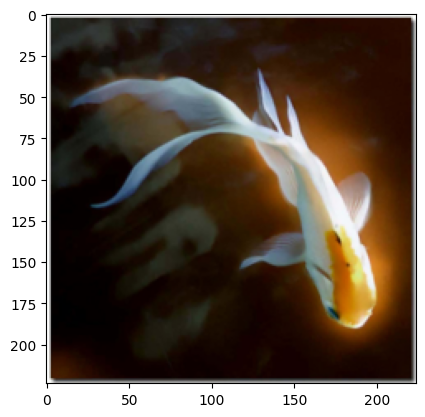

In [4]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sample_image, sample_label = dataset[50]
print(sample_label)


# Unnormalize the image
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
unnormalized_image = sample_image.squeeze().cpu().numpy().transpose(1, 2, 0)
unnormalized_image = std * unnormalized_image + mean
unnormalized_image = np.clip(unnormalized_image, 0, 1)
imshow(unnormalized_image)
show()

# make a function to denormalize the image
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    tensor = tensor * std + mean
    return tensor


with open("/home/usd.local/casey.wall/mod_gradcam/imagenet_testing/imagenet_str_classes.txt") as f:
    labels = f.readlines()
    labels = [label.strip() for label in labels]


## This code sets up being able to visualize the images and heatmaps

In [5]:
def create_colored_heatmap(matrix, size=(224, 224), colormap='Reds', op_multiplier=1.0):
    """
    Create a colored heatmap from a matrix with alpha channel.
    
    Args:
        matrix (torch.Tensor): Input matrix to convert to heatmap
        size (tuple): Target size for interpolation (default: (224, 224))
        colormap (str): Matplotlib colormap name (default: 'Reds')
        op_multiplier (float): Opacity multiplier for the heatmap (default: 1.0)
    
    Returns:
        numpy.ndarray: RGBA array with shape (H, W, 4)
    """
    # Interpolate if needed
    if isinstance(matrix, torch.Tensor):
        matrix = F.interpolate(matrix[None, None], size=size, mode="nearest-exact")
        matrix = matrix.squeeze().cpu().numpy()

    # Normalize the matrix
    normalized_matrix = (matrix - matrix.min()) / (matrix.max() - matrix.min()) if matrix.max() > matrix.min() else matrix

    # Apply colormap
    cmap = plt.colormaps.get_cmap(colormap)
    colored_matrix = cmap(normalized_matrix)[..., :3]

    # Reduce the opacity of the heatmap using the op_multiplier
    alpha_matrix = normalized_matrix * op_multiplier

    # Add alpha channel
    return np.concatenate([colored_matrix, alpha_matrix[..., None]], axis=-1)


def find_heatmap_centroid(heatmap):
    """
    Find the centroid of a heatmap based on pixel intensity values.
    
    Args:
        heatmap (torch.Tensor or np.ndarray): 2D array of intensity values between 0 and 1
        
    Returns:
        tuple: (x, y) coordinates of the centroid
    """
    
    # Convert to numpy array if it's a torch tensor
    if torch.is_tensor(heatmap):
        heatmap = heatmap.cpu().numpy()
    
    # normalize the heatmap between 0 and 1
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-6)
    
    # Create coordinate grids
    h, w = heatmap.shape
    y_coords, x_coords = np.mgrid[0:h, 0:w]
    
    # Calculate total weight (sum of all intensity values)
    total_weight = np.sum(heatmap)
    
    # Avoid division by zero
    if total_weight == 0:
        return (w // 2, h // 2)  # Return center of image if all values are zero
    
    # Calculate weighted averages
    x_centroid = np.sum(x_coords * heatmap) / total_weight
    y_centroid = np.sum(y_coords * heatmap) / total_weight
    
    return int(x_centroid), int(y_centroid)


# Apply Otsu thresholding
def generate_masked_image(image, mask):
        """
        Generate a masked version of an image by applying a binary threshold mask
        
        Args:
            image (numpy.ndarray): Original image to mask
            mask (numpy.ndarray): Binary mask to apply
            
        Returns:
            numpy.ndarray: Masked image
        """
        if torch.is_tensor(mask):
            mask = mask.cpu().numpy()
        # Apply Otsu thresholding to get binary mask
        threshold = filters.threshold_otsu(mask)
        binary_mask = mask > threshold

        # Resize binary mask to match image size using nearest-exact interpolation 
        binary_mask = F.interpolate(torch.tensor(binary_mask)[None, None].float(), 
                                size=(224, 224), 
                                mode="nearest-exact").squeeze().numpy()

        # Apply mask to image
        masked_image = image.copy()
        for i in range(3):
            masked_image[..., i] = masked_image[..., i] * binary_mask
            
        return masked_image



## This code sets different parameters for the WinsorCAM and how things are visualized

In [ ]:
# Uncomment the model you want to use
# model = InceptionV3Modified()
# model = ResNet50Modified()
model = Dense121Modified()
# model = VGG16Modified()

model.eval()

# You could modify the layer_names but it is not recommended
layer_names = [name for name, module in model.named_modules() if isinstance(module, nn.Conv2d)]

# It is possibe to change what class index to do backpropagation on but it is not recommended unless you understand the process
class_index = None


# There have bee test on aggregation methods for individual kernels but the common is to use the mean (as it is in the original Grad-CAM paper)
gradient_aggregation_method = "mean"
# This tells the method how to aggregate the importances from the entire layer
# it is most common to used either "mean" or "max"
layer_aggregation_method = "mean"
# This tell the method how to aggregate the Grad-CAM maps found from all the layers in the model
## It is most common to use weighted as this is the WinsorCAM way
## If one wanted to see the naive Grad-CAM maps averaged together they could use "mean"
stack_aggregation_method = "weighted"


# This is the percentile to use for Winsorization
## This only impacts the visualizations that have a set percentile (as opposed to the ones that calculate on a range of precentiles)
### Value between 0 and 100
winsor_percentile = 90

# this is just the index of the image in the dataset you want to visualize
index = 1215 #dog 10100 #owl1200

# These are interpolation modes for the heatmaps
## I usually use bilinear with a colormap of "nipy_spectral" for the final visualization
## If nearest-exact is it is best visualized with a colormap of "Reds" 
### Other colormaps can be used used if you want to experiment
interpolation_mode = "bilinear"
map_color = "nipy_spectral"

# interpolation_mode = "nearest-exact"
# map_color="Reds"


# This changes the opacity of the heatmap that is overlayed on the image
# at 1 the heatmap will be made very apparent and at 0 the heatmaps will not be visible
map_opacity_multiplier = .9

# This selects the device to use for the model
## If you like you could change this
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


actual label: 24: 'great grey owl, great gray owl, Strix nebulosa',
24
predicted label: 24: 'great grey owl, great gray owl, Strix nebulosa',
24


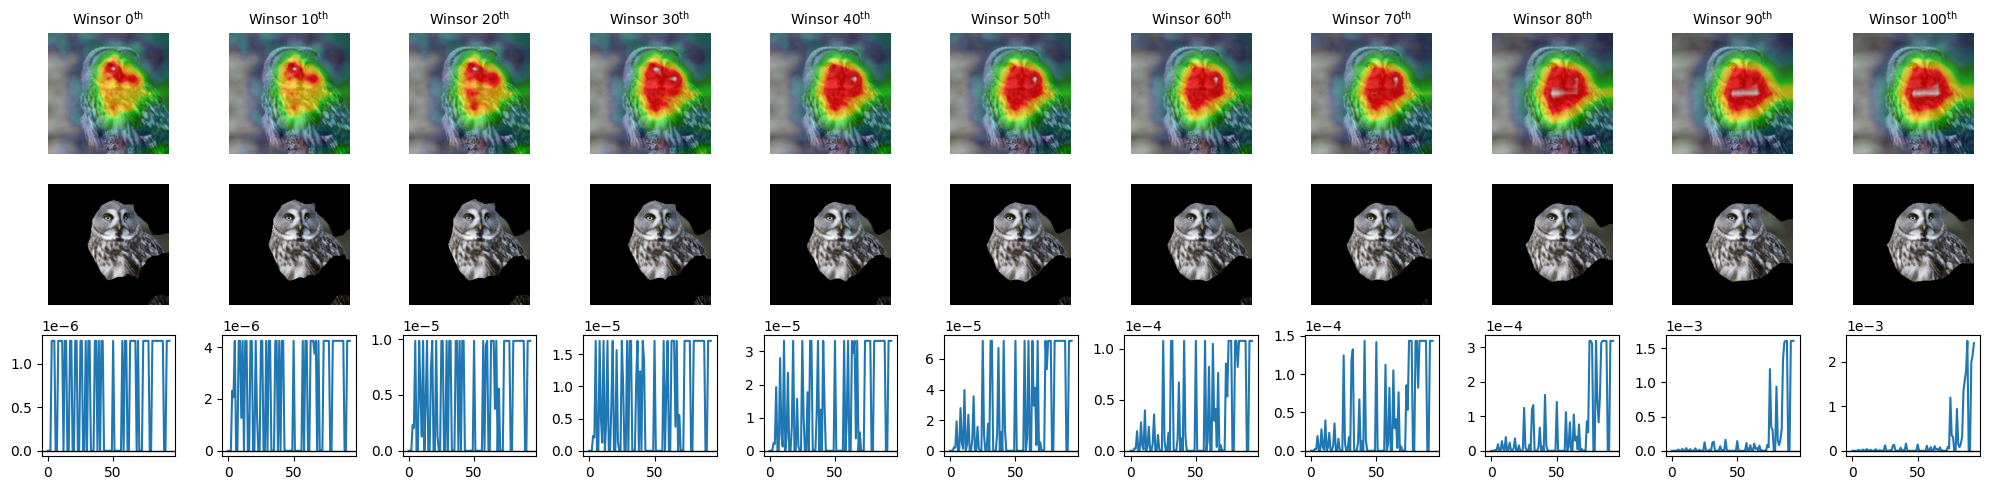

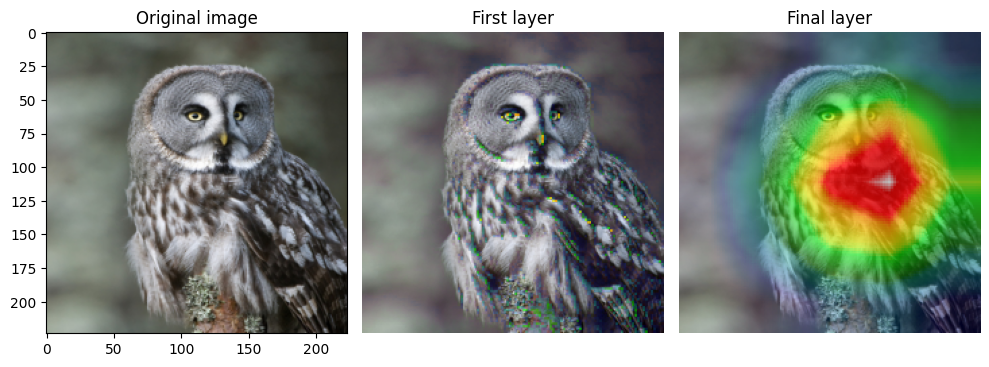

In [8]:
def show_special(model, dataset, image_number, class_index,
                 layer_names, gradient_aggregation_method,
                 stack_aggregation_method, layer_aggregation_method, 
                 stack_relu, interpolation_mode='nearest', labels = None,
                 map_color = "Reds", map_opacity_multiplier = .9):
    # Get image and prepare it
    input_tensor, sample_label = dataset[image_number]
    input_tensor = input_tensor.unsqueeze(0)
    input_tensor = input_tensor.to(device)
    
    # First run YOUR implementation (with fresh hooks)
    model.storage.clear()  # Ensure storage is clear
    model._unregister_hooks()  # Remove any existing hooks
    model._register_hooks()    # Register fresh hooks
    
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
    predicted_class = torch.argmax(output).item()
    print(f"actual label: {labels[sample_label]}")
    print(sample_label)
    print(f"predicted label: {labels[predicted_class]}")
    print(predicted_class)
    
    model.storage.clear()  # Ensure storage is clear
    model._unregister_hooks()  # Remove any existing hooks
    model._register_hooks()    # Register fresh hooks

    # use get_gradcams_and_importance
    stacked_gradcam, gradcams, importance_tensor = model.get_gradcams_and_importance(input_tensor.to(device),
                                                                                 predicted_class, layer_names,
                                                                                 gradient_aggregation_method,
                                                                                 layer_aggregation_method, True,
                                                                                 interpolation_mode=interpolation_mode)

    
    # show the image
    unnormalized_image = denormalize(input_tensor.squeeze(0).cpu()).squeeze(0).permute(1, 2, 0).numpy()
    # imshow(unnormalized_image)
    # show()

    fig, axs = plt.subplots(3, 11, figsize=(20, 5))
    for idx, i in enumerate(np.arange(0, 101, 10)):
        # use winsorize_stacked_gradcam
        winsor_gradcam, grads = model.winsorize_stacked_gradcam(input_tensor, stacked_gradcam, gradcams, 
                                                        importance_tensor, 
                                                        interpolation_mode=interpolation_mode, 
                                                        winsor_percentile=i)
        # show the gradcam each time
        axs[0, idx].imshow(unnormalized_image)
        axs[0, idx].imshow(create_colored_heatmap(winsor_gradcam.squeeze(), op_multiplier=map_opacity_multiplier, colormap=map_color))
        axs[0, idx].set_title(f"Winsor {i}$^{{\\text{{th}}}}$", fontsize=10)
        axs[0, idx].axis("off")
        
        # show the masked image below the gradcam
        masked_image = generate_masked_image(unnormalized_image, winsor_gradcam.squeeze())
        axs[1, idx].imshow(masked_image)
        axs[1, idx].axis("off")
        
        # plot the grads in the third row
        axs[2, idx].plot(grads.squeeze().cpu().numpy())
        axs[2, idx].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        axs[2, idx].axhline(0, color='black', lw=1)
    plt.tight_layout()
    plt.show()

    # now campare the gradcam of the first layer with that of the last layer
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(unnormalized_image)
    axs[0].set_title(f"Original image")
    axs[1].imshow(unnormalized_image)
    axs[1].imshow(create_colored_heatmap(gradcams[0].squeeze(), op_multiplier=1, colormap=map_color))
    axs[1].set_title(f"First layer")
    axs[1].axis("off")
    axs[2].imshow(unnormalized_image)
    axs[2].imshow(create_colored_heatmap(gradcams[-1].squeeze(), op_multiplier=map_opacity_multiplier, colormap=map_color))
    axs[2].set_title(f"Final layer")
    axs[2].axis("off")
    plt.tight_layout()
    plt.show()


show_special(model, dataset, index, class_index, layer_names,
             gradient_aggregation_method, stack_aggregation_method,
             layer_aggregation_method, True,
             interpolation_mode=interpolation_mode, labels=labels,
             map_color=map_color, map_opacity_multiplier=map_opacity_multiplier)

In [ ]:

def generate_gradcam_gif(model, dataset, index, class_index, layer_names,
                         gradient_aggregation_method, stack_aggregation_method,
                         layer_aggregation_method, stack_relu, 
                         interpolation_mode='nearest',
                         temp_dir="temp", gif_name="gradcam.gif", labels=None,
                         map_color="Reds", map_opacity_multiplier=1.,
                         needed_class=None, winsor_range=np.arange(0, 101, 10)):
    """
    Generate a GradCAM GIF for different winsor percentiles.

    Args:
        model: The model to generate GradCAMs from
        dataset: The dataset to generate GradCAMs for
        index: The index of the image in the dataset
        class_index: The index of the class to generate
        layer_names: The names of the layers to generate GradCAMs for
        gradient_aggregation_method: The method to aggregate gradients
        stack_aggregation_method: The method to aggregate stacked GradCAMs
        layer_aggregation_method: The method to aggregate layer GradCAMs
        stack_relu: Whether to apply ReLU to stacked GradCAMs
        interpolation_mode: The interpolation mode for resizing
        temp_dir: The temporary directory to store images
        gif_name: The name of the output
    """
    
    # Create a temporary directory to store the images
    os.makedirs(temp_dir, exist_ok=True)


    input_tensor, sample_label = dataset[index]
    # label = fix_label(label.squeeze().cpu())
    input_tensor = input_tensor.unsqueeze(0)
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    unnormalized_image = input_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    unnormalized_image = std * unnormalized_image + mean
    unnormalized_image = np.clip(unnormalized_image, 0, 1)

    model.to(device)
    input_tensor = input_tensor.to(device)
    
    # sample_label = torch.argmax(one_hot).item()
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
    predicted_class = torch.argmax(output).item()
    print(f"Predicted class: {predicted_class}")
    print(f"predicted class name:{labels[predicted_class]}")
    # using argmax on the one hot get the actual class
    print(f"actual class: {labels[sample_label]}")
    model.storage.clear()  # Ensure storage is clear
    model._unregister_hooks()  # Remove any existing hooks
    model._register_hooks()    # Register fresh hooks
    stacked_gradcam, gradcams, importance_tensor = model.get_gradcams_and_importance(input_tensor.to(device),
                                                        predicted_class, layer_names,
                                                        gradient_aggregation_method,
                                                        layer_aggregation_method, True,
                                                        interpolation_mode=interpolation_mode)

    # Generate GradCAMs for different winsor percentiles
    for winsor in tqdm(winsor_range, desc="Generating GradCAMs", unit="winsor"):
        winsor_gradcam, grads = model.winsorize_stacked_gradcam(input_tensor, stacked_gradcam, gradcams, 
                                                       importance_tensor, 
                                                       interpolation_mode=interpolation_mode, 
                                                       winsor_percentile=winsor)


        
        # raise ValueError("Stop here")


        # Create a figure with 3 subplots
        fig, ax = plt.subplots(1, 3, figsize=(10, 5))
        fig.suptitle(f"GradCAM Winsor {winsor}", fontsize=16, y=0.95)
        ax[0].imshow(unnormalized_image)
        ax[0].imshow(create_colored_heatmap(winsor_gradcam.squeeze(), op_multiplier=map_opacity_multiplier, colormap=map_color))
        masked_image = generate_masked_image(unnormalized_image, winsor_gradcam.squeeze())
        x, y = find_heatmap_centroid(winsor_gradcam.squeeze())
        ax[1].imshow(masked_image)
        ax[1].scatter(x, y, c='red', marker='x')

        ax[2].plot(grads.squeeze().cpu().numpy())

        plt.savefig(os.path.join(temp_dir, f"{winsor}.png"))
        plt.close()

    # Create a GIF from the saved images
    image_files = [os.path.join(temp_dir, f"{winsor}.png") for winsor in winsor_range]
    images = [imageio.v2.imread(file) for file in image_files]
    imageio.mimsave(gif_name, images, duration=1000)

    # Remove the temporary directory
    shutil.rmtree(temp_dir)



generate_gradcam_gif(model, dataset, index, class_index, layer_names,
        gradient_aggregation_method, stack_aggregation_method,
        layer_aggregation_method, True, 
        interpolation_mode=interpolation_mode,
        temp_dir="temp", gif_name="./examples/winsorcam_imagenet.gif", labels=labels,
        map_color=map_color, map_opacity_multiplier=map_opacity_multiplier,
        needed_class=None, winsor_range=np.arange(0, 101, 1))
     

Predicted class: 24
predicted class name:24: 'great grey owl, great gray owl, Strix nebulosa',
actual class: 24: 'great grey owl, great gray owl, Strix nebulosa',


Generating GradCAMs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:25<00:00,  3.93winsor/s]
